In [57]:
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
ts = pd.read_excel("data/stock_prices.xlsx", usecols = ["Date", "Adj Close", "Volume"])
ts["Close_Diff"] = ts["Adj Close"].diff()

In [3]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(ts.loc[:, ["Adj Close"]].dropna()) # For using stock prices
#training_set_scaled = sc.fit_transform(ts.loc[:, ["Close_Diff"]].dropna()) # For using percentage differences

In [4]:
# Train, test split
series = training_set_scaled
train_size = int(round(len(series) * 0.80, 0))

train_set = series[:train_size]
test_set = series[train_size:]

In [5]:
assert (len(train_set) + len(test_set)) == len(series)

In [6]:
def create_dataset(dataset, look_back = 1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [7]:
LOOK_BACK = 2
X_train, y_train = create_dataset(train_set, LOOK_BACK)
X_test, y_test = create_dataset(test_set, LOOK_BACK)

In [8]:
X_train.shape

(364, 2)

In [9]:
# The LSTM network expects the input data (X) to be provided in the form of: [samples, time steps, features].
# Currently, our data is in the form: [samples, features]
def reshape_data(X_train, X_test):
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    return X_train, X_test

X_train, X_test = reshape_data(X_train, X_test)

In [10]:
X_train.shape

(364, 1, 2)

In [12]:
def build_model(opt, d, l):
    model = Sequential()
    model.add(LSTM(4, input_shape = (1, l), dropout = d)) # , return_sequences = True
    # model.add(LSTM(4, input_shape = (1, l))) # If more layers are included, the comment from above also needs to be included.
    model.add(Dense(1))
    model.compile(optimizer = opt, loss = 'mean_squared_error', metrics = 'RootMeanSquaredError')
    return model

In [12]:
param_list = []

opti = ["rmsprop", "SGD", "Adam"]
drop = [0, 0.1, 0.2]
l_back = [1, 2, 3, 4, 5]

for l in l_back:
    X_train, y_train = create_dataset(train_set, l)
    X_test, y_test = create_dataset(test_set, l)
    X_train, X_test = reshape_data(X_train, X_test)
    for opt in opti:
        for d in drop:
            model = build_model(opt, d, l)
            history = model.fit(X_train, y_train, epochs = 100, batch_size = 1, validation_split = 0.2, verbose = 0)
            param_list.append("D.Out.: " + str(d) + 
                                    " & Opt: " + opt +
                                    " & Lookback: " + str(l) +
                                    " ;Train RMSE: " + str(history.history['root_mean_squared_error']) + 
                                    " ;Train Loss: "+ str(history.history['loss']) + 
                                    " ;Val RMSE:" + str(history.history['val_root_mean_squared_error']) +
                                    " ;Val Loss:" + str(history.history['val_loss'])
                                    )

2022-01-01 20:45:10.450530: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
params = []
train_rmse = []
val_rmse = []
train_loss = []
val_loss = []

for item in param_list:
    params.append(item.split(";")[0])
for item in param_list:
    train_rmse.append(item.split(";")[1][13:-2].split(", "))
for item in param_list:
    train_loss.append(item.split(";")[2][13:-2].split(", "))
for item in param_list:
    val_rmse.append(item.split(";")[3][10:-2].split(", "))
for item in param_list:
    val_loss.append(item.split(";")[4][10:-1].split(", "))

e = list(np.arange(1, len(val_rmse[0])+1, 1))

In [14]:
from itertools import chain

df = pd.DataFrame({
    "Epoch": [item for item in e*len(val_loss)],
    "Params": [item for item in sorted(params * len(e))],
    "Train_RMSE": [item for item in list(chain.from_iterable(train_rmse))],
    "Train_Loss": [item for item in list(chain.from_iterable(train_loss))],
    "Val_RMSE": [item for item in list(chain.from_iterable(val_rmse))],
    "Val_Loss": [item for item in list(chain.from_iterable(val_loss))]
    }
)

In [17]:
df.to_csv("./eval_model/lstm_no_sentiment.csv", sep='\t')

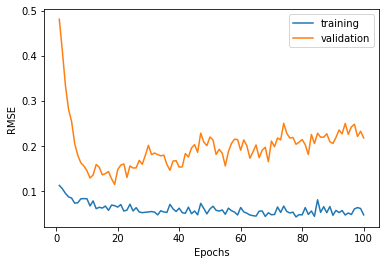

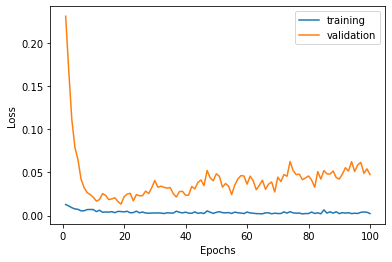

In [16]:
import matplotlib.pyplot as plt

rmse_history = history.history["root_mean_squared_error"]
val_rmse_history = history.history["val_root_mean_squared_error"]

plt.plot(range(1, len(rmse_history) + 1), rmse_history)
plt.plot(range(1, len(val_rmse_history) + 1), val_rmse_history)
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend(["training", "validation"])
plt.show()

loss_history = history.history["loss"]
val_loss_history = history.history["val_loss"]

plt.plot(range(1, len(loss_history) + 1), loss_history)
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["training", "validation"])
plt.show()

# Best model

In [13]:
param_list = []

opti = ["Adam"]
drop = [0]
l_back = [1]

for l in l_back:
    X_train, y_train = create_dataset(train_set, l)
    X_test, y_test = create_dataset(test_set, l)
    X_train, X_test = reshape_data(X_train, X_test)
    for opt in opti:
        for d in drop:
            model = build_model(opt, d, l)
            history = model.fit(X_train, y_train, epochs = 35, batch_size = 1,  verbose = 0)
            param_list.append("D.Out.: " + str(d) + 
                                    " & Opt: " + opt +
                                    " & Lookback: " + str(l) +
                                    " ;Train RMSE: " + str(history.history['root_mean_squared_error']) + 
                                    " ;Train Loss: "+ str(history.history['loss'])
                                    )

2022-01-02 10:34:18.972519: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = sc.inverse_transform(model.predict(X_train))
testPredict  = sc.inverse_transform(model.predict(X_test))
testScore = math.sqrt(mean_squared_error(y_test, testPredict))

In [25]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = testPredict
y_test_inv_trans = sc.inverse_transform(y_test.reshape(-1, 1))

testscore_rmse = math.sqrt(mean_squared_error(y_test_inv_trans, y_pred))
testscore_mse = mean_squared_error(y_test_inv_trans, y_pred)
testscore_mae = mean_absolute_error(y_test_inv_trans, y_pred)

print("RMSE: ", testscore_rmse, "MSE: ", testscore_mse, "MAE: ", testscore_mae)

RMSE:  9.101220400562442 MSE:  82.83221277961395 MAE:  7.264487711588539


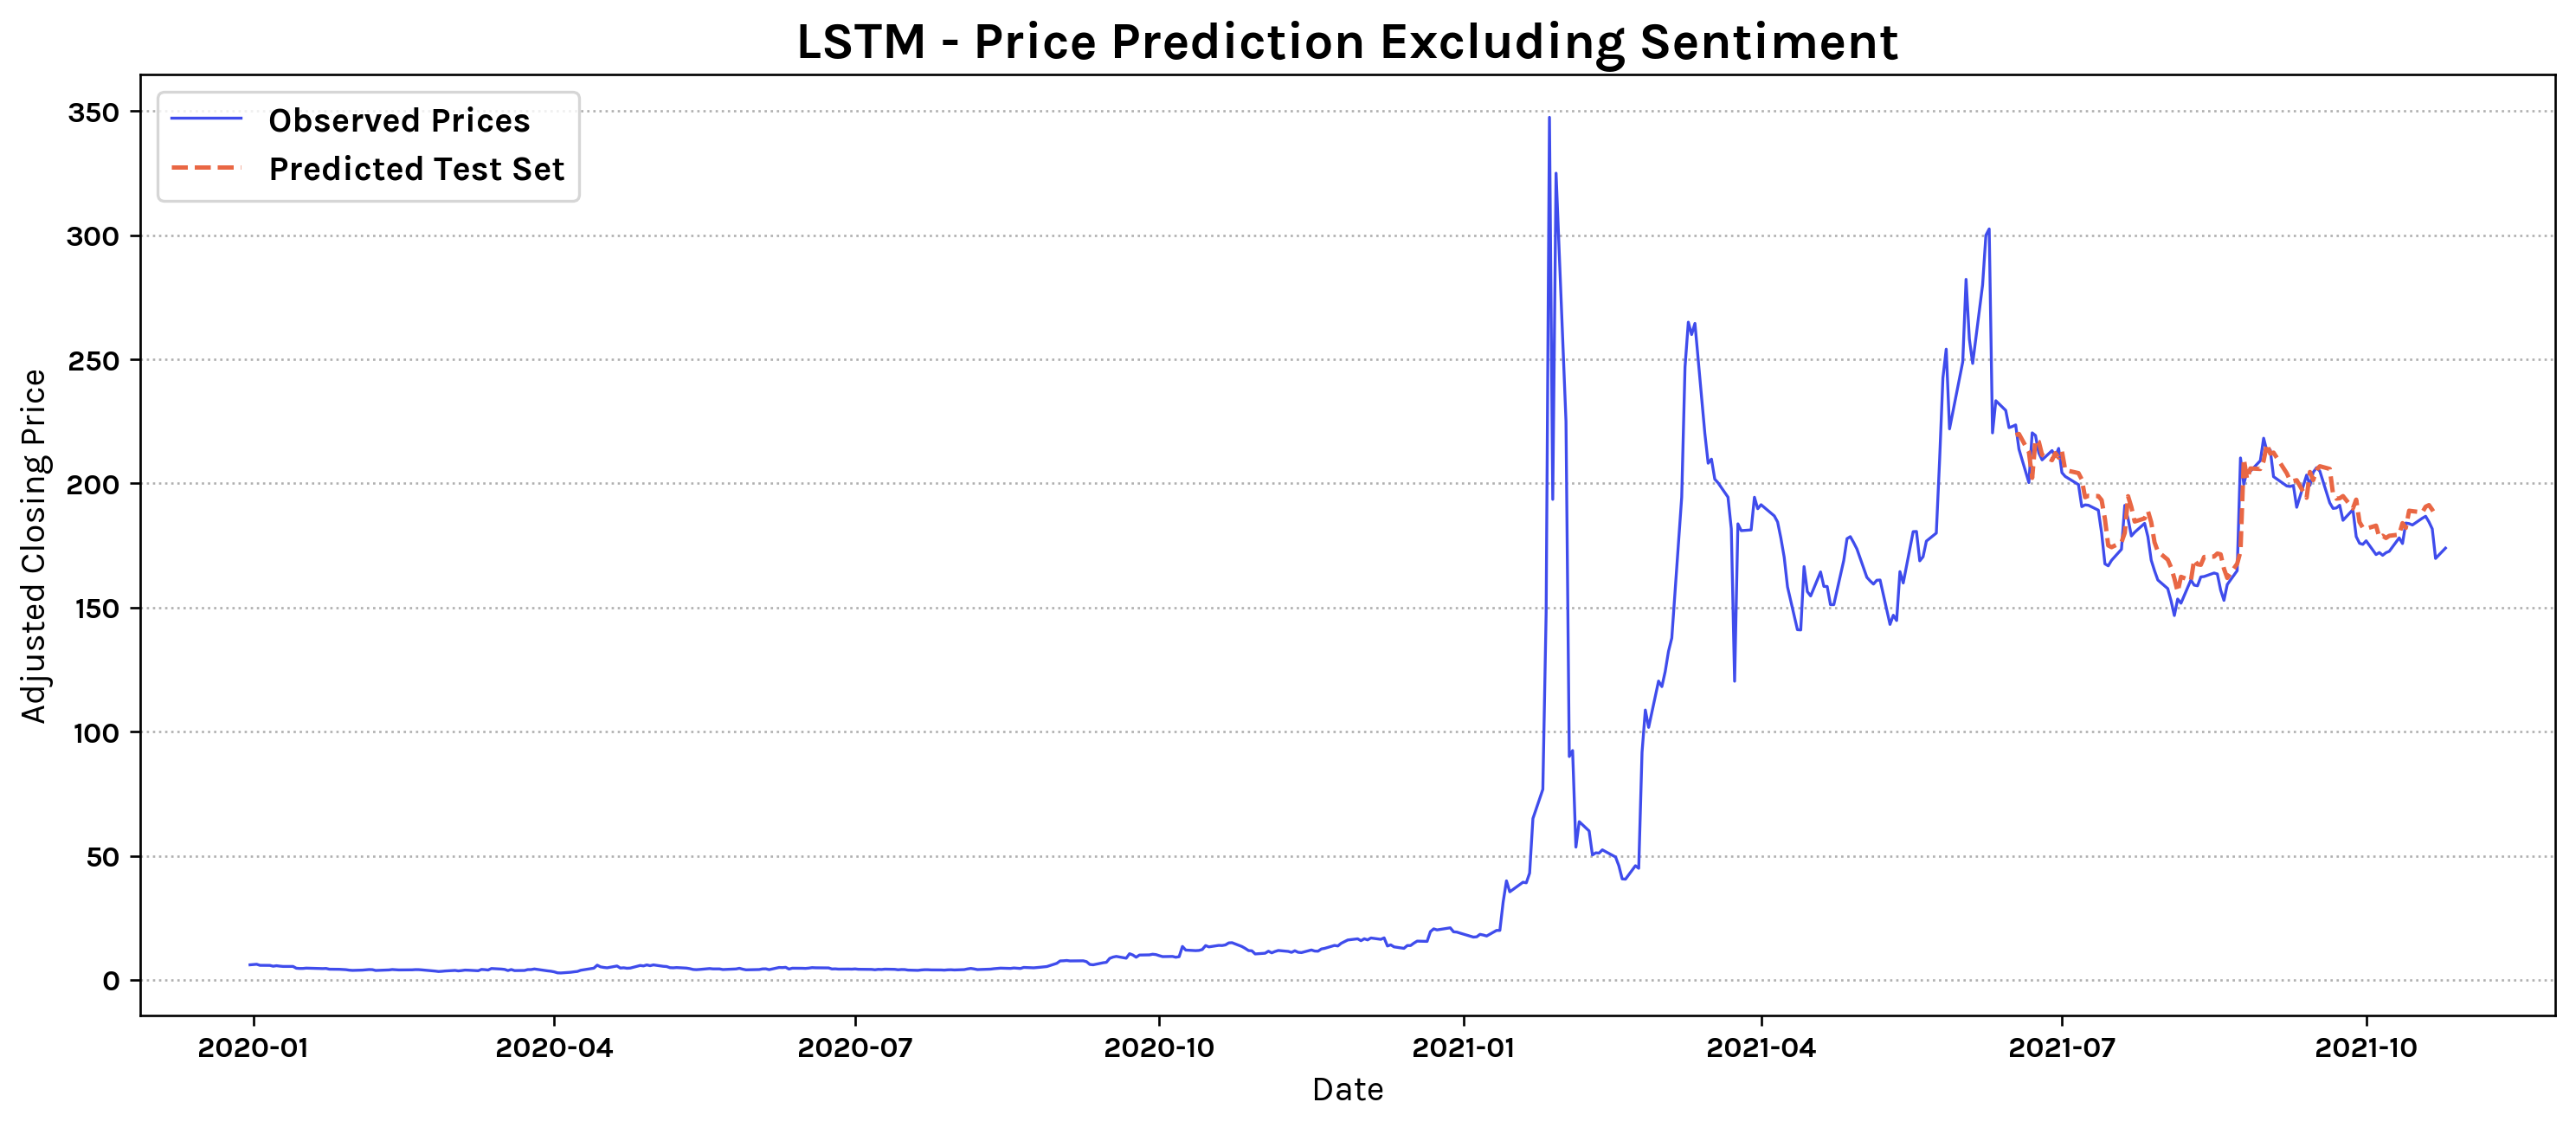

In [16]:
plt.rcParams['font.sans-serif'] = "Karla"
plt.rcParams["font.weight"] = "bold"

from matplotlib.pyplot import figure

figure(figsize=(15, 6), dpi=240)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(training_set_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[l:len(trainPredict)+l, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(training_set_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(l*2)+1:len(training_set_scaled)-1, :] = testPredict
# plot baseline and predictions

x = ts.Date

plt.plot(x, sc.inverse_transform(training_set_scaled), color = "#3F4CEC", linewidth = 1, label = "Observed Prices")
# plt.plot(x, trainPredictPlot, color = "#FFC322", linestyle='dashed', label = "Predicted Train Set")
plt.plot(x, testPredictPlot, color = "#E96744", linestyle='dashed', label = "Predicted Test Set")
plt.legend(loc="upper left", prop={'size': 12})
plt.ylabel("Adjusted Closing Price", fontsize = 12)
plt.grid(axis = "y", linestyle = "dotted")
plt.xlabel("Date", fontsize = 12)
plt.title("LSTM - Price Prediction Excluding Sentiment", fontsize = 18, weight = "bold")

plt.show()